<center><img src = "https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png" width = "800"/></center>
<center><str><a target="_blank" href="https://www.med.upenn.edu/cbica/assets/user-content/images/BraTS/BRATS_banner_noCaption.png">Image Source</a></str></center>

This notebook focuses on the preprocessing of the BraTS 2020 dataset for brain tumor segmentation. The BraTS 2020 dataset consists of multimodal MRI scans along with manual segmentations of brain tumors, essential for developing machine learning models for accurate and automated tumor segmentation.

The preprocessing steps covered include:
1. **Loading the dataset and necessary libraries** to handle medical images.
2. **Splitting the dataset** into training, testing and validation sets to evaluate model performance.
3. **Visualizing MRI scans** and their corresponding ground truth segmentations to understand the datasest.
4. **Preparing the data** for modeling, including normalization, resizing and augmentation.

This preparation is crucial for any subsequent model training and evaluation, aiming to improve the accuracy and efficency of brain tumor segmentation.

# Dataset Information

The Brain Tumor Segmentation (BraTS) 2020 dataset is a collection of multimodal Magnetic Resonance Imaging (MRI) scans used for the segmentation of brain tumors. These are Multimodal scans available as NIfTI files (.nii.gz).

It includes MRI scans from glioma patients, providing four different MRI modalities (means 4 channels of information - 4 different volumes of the same region) per patient:
1. **Native (T1)**
2. **T1 with contrast enhancement (T1ce)**
3. **T2-weighted (T2)**
4. **T2 Fluid Attenuated Inversion Recovery (FLAIR) volumes**

These scans come with expert-annotated segmentation masks that delineate the tumor into various sub-regions, such as the necrotic and non-enhancing tumor core, the peritumoral edema, and the enhancing tumor.

Annotations (labels):
  1. **Label 0**: Unalbeled volume
  2. **Label 1**: Necrotic and non-enhancing tumor core (NCR/NET)
  3. **Label 2**: Peritumoral edema (ED)
  4. **Label 3**: Missing (No pixels in all the volumes contain label 3)
  5. **Label 4**: GD-enhancing tumor (ET)

As there are no pixels with the label 3, we will be reassigning label 3 with label 4 so that there is continuity between the labels.

We will combine FLAIR, T1ce and T2 into a single volume as it will give us rich information. And we will ignore T1 as the features we see in the mask are clearly visible in T1ce, T2 and FLAIR.

# Loading the Necessary Libraries

In [41]:
import numpy as np
import nibabel as nib
import glob
import shutil
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from skimage.util import montage
from skimage.transform import rotate
from skimage.transform import resize
from sklearn.preprocessing import MinMaxScaler

# Load Sample Images and Visualize

In [26]:
TRAIN_DATASET_PATH = "D:/Brain Tumor Segmentation FYP/Dataset/BraTS2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/"

In [27]:
# load .nii file as a numpy array
test_image_flair = nib.load(TRAIN_DATASET_PATH + "BraTS20_Training_355/BraTS20_Training_355_flair.nii").get_fdata()
print("Shape: ", test_image_flair.shape)
print("Dtype: ", test_image_flair.dtype)

Shape:  (240, 240, 155)
Dtype:  float64


In [28]:
print(test_image_flair.max())

1854.603271484375


As we can see the maximum pixel value of the image is "1854.6" which gives us a good idea to rescale these values. Rescaling pixel values is essential because it standardizes the intensity values across multimodal MRI scans (T1, T1ce, T2, FLAIR) to a uniform scale. This uniformity is crucial for consistent model training and analysis, as it ensures that variations in pixel intensity due to different imaging modalities and equipment do not bias the segmentation model. It facilitates the model's ability to learn meaningful features from the data for accurate tumor segmentation, regardless of the inherent differences in the raw MRI scans.

In [29]:
scaler = MinMaxScaler()

In [30]:
# Scale the test_image_flair array and then reshape it back to its original dimensions.
# This ensures the data is normalized/standardized for model input without altering its spatial structure.
test_image_flair = scaler.fit_transform(test_image_flair.reshape(-1, test_image_flair.shape[-1])).reshape(test_image_flair.shape)

In [31]:
print(test_image_flair.max())

1.0


Now we can see that the pixel values are scaled between 0 - 1.

In [32]:
# rescaling t1
test_image_t1 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1.nii').get_fdata()
test_image_t1 = scaler.fit_transform(test_image_t1.reshape(-1, test_image_t1.shape[-1])).reshape(test_image_t1.shape)

# rescaling t1ce
test_image_t1ce = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t1ce.nii').get_fdata()
test_image_t1ce = scaler.fit_transform(test_image_t1ce.reshape(-1, test_image_t1ce.shape[-1])).reshape(test_image_t1ce.shape)

# rescaling t2
test_image_t2 = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_t2.nii').get_fdata()
test_image_t2 = scaler.fit_transform(test_image_t2.reshape(-1, test_image_t2.shape[-1])).reshape(test_image_t2.shape)

# we will not rescale the mask
test_mask = nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_355/BraTS20_Training_355_seg.nii').get_fdata()

In [33]:
print("Before: ", test_mask.dtype)

Before:  float64


In [34]:
# converting to integer
test_mask = test_mask.astype(np.uint8)
print("After: ", test_mask.dtype)

After:  uint8


In [35]:
#0, 1, 2, 4 (Need to re-encode to 0, 1, 2, 3)
print(np.unique(test_mask))

[0 1 2 4]


In [36]:
# re-assigning mask values 4 to 3
test_mask[test_mask==4] = 3
print(np.unique(test_mask))

[0 1 2 3]


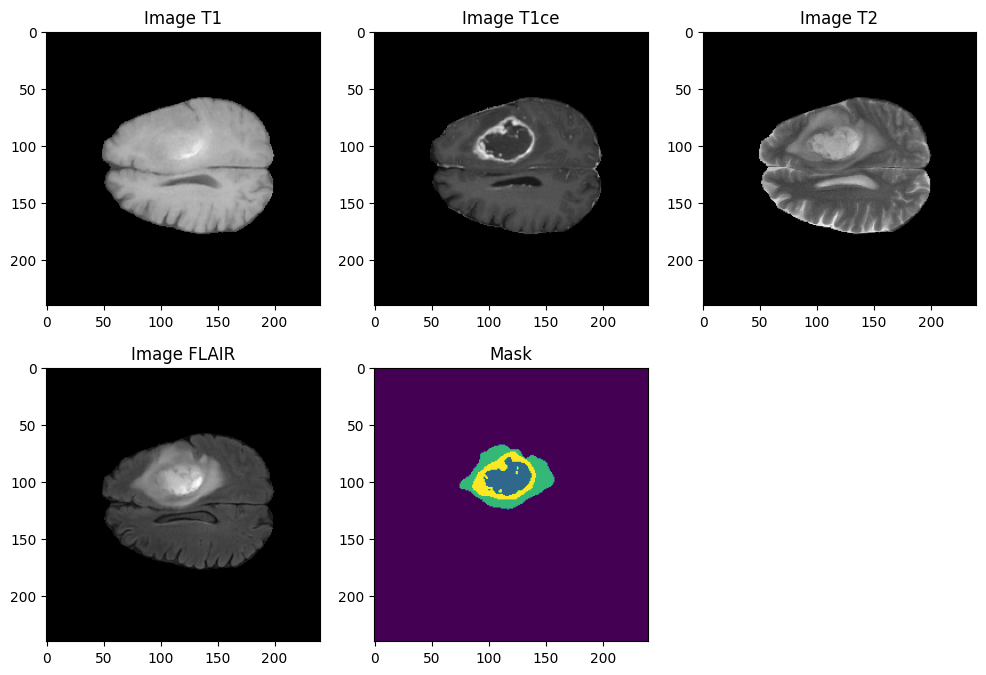

In [37]:
# import random
# n_slice=random.randint(0, test_mask.shape[2])

slice_w = 25

plt.figure(figsize=(12, 8))

# Image T1
plt.subplot(2, 3, 1)
plt.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap='gray')
plt.title('Image T1')

# Image T1ce
plt.subplot(2, 3, 2)
plt.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap='gray')
plt.title('Image T1ce')

# Image T2
plt.subplot(2, 3, 3)
plt.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap='gray')
plt.title('Image T2')

# Image Flair
plt.subplot(2, 3, 4)
plt.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap='gray')
plt.title('Image FLAIR')

# Mask
plt.subplot(2, 3, 5)
plt.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
plt.title('Mask')
plt.show()

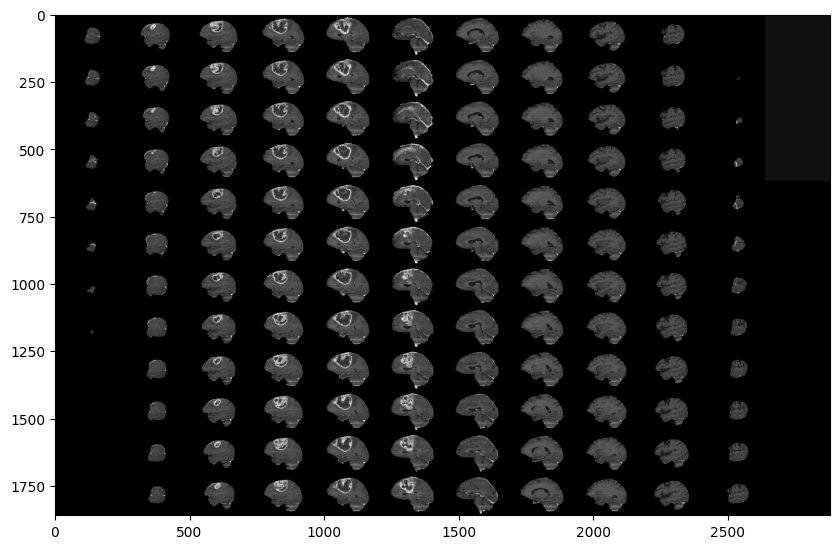

In [38]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_image_t1ce[50:-50,:,:]), 90, resize=True), cmap ='gray');

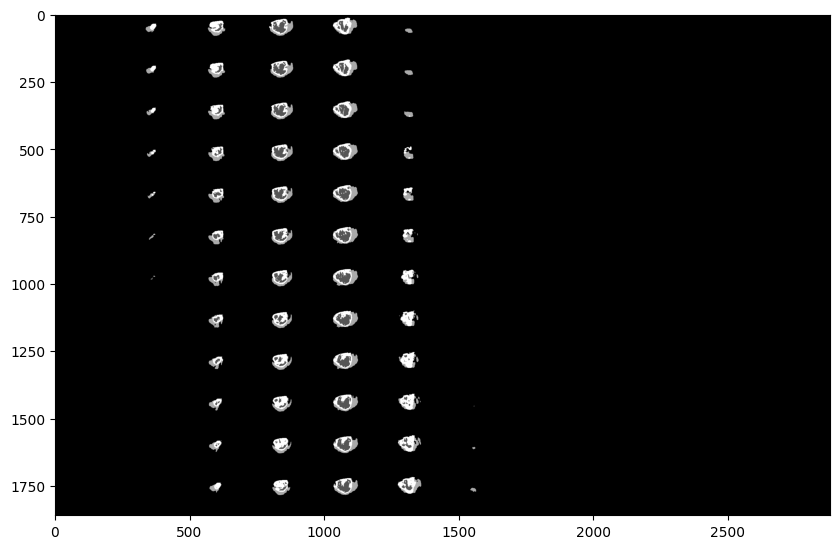

In [43]:
# Skip 50:-50 slices since there is not much to see
fig, ax1 = plt.subplots(1, 1, figsize = (10,10))
ax1.imshow(rotate(montage(test_mask[50:-50,:,:]), 90, resize=True), cmap ='gray');